In [1]:
from fastai.vision.all import *
import warnings
from PIL import Image

path = Path('inputs')/'processed'
warnings.filterwarnings("ignore")

In [2]:
ims = get_image_files(path)
total_images = len(ims)
print(f"Total images: {total_images}")

Total images: 12643


In [3]:
import torch; print(torch.cuda.get_device_name(0))

# Flush CUDA memory
torch.cuda.empty_cache()

import gc
gc.collect()

NVIDIA GeForce RTX 4070 Ti


66

In [4]:
import os

def _my_grandparent_idxs(items, name):
    def _inner(items, name): 
        return mask2idxs(name in str(Path(o)) for o in items)
    return [i for n in L(name) for i in _inner(items,n)]

def MyGrandparentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the grand parent folder names (`train_name` and `valid_name`)."
    def _inner(o):
        return _my_grandparent_idxs(o, train_name),_my_grandparent_idxs(o, valid_name)
    return _inner
    


In [5]:
fnames = [
    path/'train/cat/a/9932.png', path/'valid/cat/a/7189.png',
    path/'train/cat/b/9932.png', path/'valid/cat/b/7189.png',
    path/'train/not-a-pet/9932.png', path/'valid/not-a-pet/7189.png',
]
splitter = MyGrandparentSplitter()

In [6]:
def _test_splitter(f, items=None):
    "A basic set of condition a splitter must pass"
    items = ifnone(items, range_of(30))
    trn,val = f(items)
    assert 0<len(trn)<len(items)
    assert all(o not in val for o in trn)
    test_eq(len(trn), len(items)-len(val))
    # test random seed consistency
    test_eq(f(items)[0], trn)
    return trn, val

In [7]:
_test_splitter(splitter, items=fnames)
test_eq(splitter(fnames),[[0,2,4],[1,3,5]])

In [8]:
def parent_label_list(o):
    """
    Returns the parent label of the image as a list
    This is required for a Miltilabel classification problem

    Args:
        o (_type_): _description_

    Returns:
        _type_: _description_
    """
    label = parent_label(o)
    grand_parent_label = o.parent.parent.name
    if label == 'not-a-pet':
        return label
    
    return label


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=MyGrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label_list,
    # not required as i am pre-processing images
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(
            size=224,
            min_scale=0.75,
            flip_vert=False,
            max_rotate=10.0,
            max_zoom=1.1,
            max_lighting=0.2,
            max_warp=0.2,
            p_affine=0.75,
            p_lighting=0.75),
        Normalize.from_stats(*imagenet_stats)
    ])

dblock.summary(path)


Setting-up type transforms pipelines
Found 12643 items
2 datasets of sizes 10097,1286
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label_list -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=736x1108
  Pipeline: parent_label_list -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying parent_label_list gives
      Abyssinian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImage mode=RGB size=736x1108, TensorCategory(0))


Found 12643 items
2 datasets of sizes 10097,1286
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label_list -

In [9]:

dls = dblock.dataloaders(path, bs=32)
print(dls.vocab)


['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'not-a-pet']


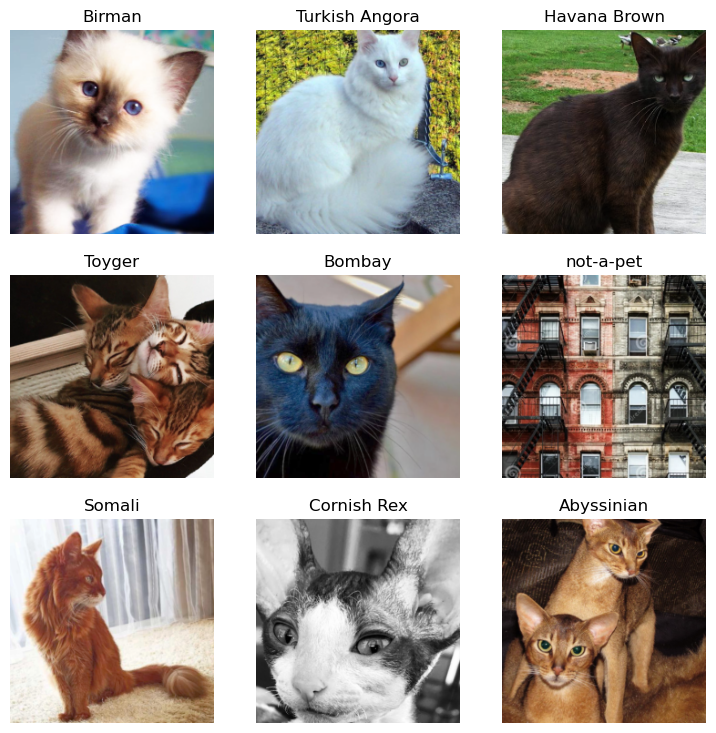

In [10]:
# dls.summary(path)
dls.show_batch(max_n=9)


Output shape: torch.Size([32, 768])


Minimum/10: 8.32e-05, steepest point: 2.75e-04
Slide: 3.02e-05, Valley: 3.63e-05


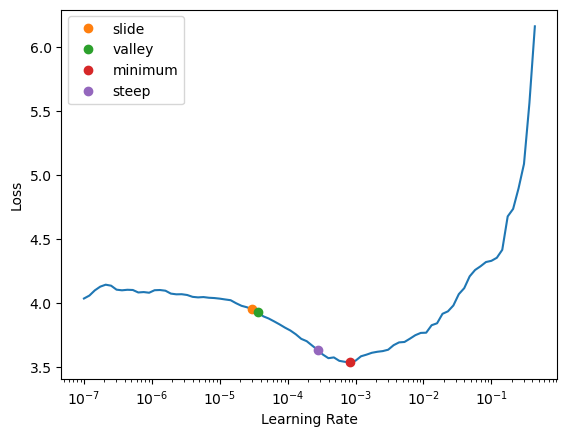

In [11]:
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from fastai.vision.all import *
import timm

# Define the CustomHead class with shape inspection
class CustomHead(nn.Module):
    def __init__(self, nf, n_out):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(nf, n_out)

    def forward(self, x):
        if x.dim() == 2:  # No spatial dimensions (1D features per image)
            # print("Input is 2D, skipping pooling.")
            x = self.flatten(x)
        elif x.dim() == 4:  # Regular case: [batch_size, channels, height, width]
            x = self.pool(x)
            # print(f"Shape after pooling: {x.shape}")
            x = self.flatten(x)
        else:
            raise ValueError(f"Unexpected input dimension: {x.dim()} dimensions.")
        # print(f"Shape after flattening: {x.shape}")
        x = self.linear(x)
        return x

# Create the model
# model_name = 'resnet18'  # Replace with your model name
model_name = 'convnext_tiny'  # Replace with your model name
# model_name = 'convnext_large'  # Replace with your model name
the_model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=0)  # num_classes=0 to exclude the final layer

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
the_model.to(device)

# Inspect the output shape
x, _ = dls.one_batch()
x = x.to(device)  # Move the input tensor to the same device as the model
with torch.no_grad():
    output = the_model(x)
print(f"Output shape: {output.shape}")

# Extract the number of features
nf = output.shape[1] if output.dim() == 4 else output.shape[-1]  # Handle cases where output is 1D or 4D

# Combine the backbone and custom head
model = nn.Sequential(
    the_model,
    CustomHead(nf=nf, n_out=len(dls.vocab))
)

# Create the learner
learn = Learner(
    dls,
    model,
    # loss_func=BCEWithLogitsLoss(),
    metrics=accuracy
).to_bf16()

# Create the learner
# learn = vision_learner(
#     dls,
#     # resnet50,
#     resnet101,
#     # resnet152,
#     loss_func=BCEWithLogitsLoss(),
#     metrics=accuracy_multi
# ).to_bf16()

lr_slide, lr_valley, lr_min, lr_steep = learn \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))
    
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Slide: {lr_slide:.2e}, Valley: {lr_valley:.2e}")

In [12]:
# learn.fine_tune(12, base_lr=lr_min, freeze_epochs=3)
# learn.export('convnext_tiny.pkl')

In [13]:

def parent_label_list_2(o):
    """
    Returns the parent label of the image as a list
    This is required for a Miltilabel classification problem

    Args:
        o (_type_): _description_

    Returns:
        _type_: _description_
    """
    label = parent_label(o)
    grand_parent_label = o.parent.parent.name
    if label == 'not-a-pet':
        return label
    else:
        return "pet"

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=MyGrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=[parent_label_list, parent_label_list_2],
    n_inp=1,
    item_tfms=Resize(460),
    batch_tfms=[
            *aug_transforms(
                size=224,
                min_scale=0.75,
                flip_vert=False,
                max_rotate=10.0,
                max_zoom=1.1,
                max_lighting=0.2,
                max_warp=0.2,
                p_affine=0.75,
                p_lighting=0.75),
            Normalize.from_stats(*imagenet_stats)
        ])

dblock.summary(path)


Setting-up type transforms pipelines
Found 12643 items
2 datasets of sizes 10097,1286
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label_list -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up Pipeline: parent_label_list_2 -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=736x1108
  Pipeline: parent_label_list -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      inputs/processed/train/cats/Abyssinian/000c79b4-d828-4e54-a0d0-341fbc898aef.jpg
    applying parent_label_list gives
      Abyssinian
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(0)
  Pipeline: parent_label_list_2 -> Categorize -- {'vocab': None, 'sort': True, 'add_na': F

In [14]:
dls = dblock.dataloaders(path, bs=32)

In [15]:
dls.vocab

(#2) [['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'not-a-pet'],['not-a-pet', 'pet']]

In [22]:
import torch.nn as nn
import timm

# Define the model architecture with timm
class TimmTwoHeadModel(nn.Module):
    def __init__(self, model_name, num_classes1, num_classes2):
        super().__init__()
        # Load the timm model without the classifier head
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        # Get the number of features from the timm model's backbone
        num_features = self.backbone.num_features
        
        # Define two separate classification heads
        self.head1 = nn.Linear(num_features, num_classes1)  # First category head
        self.head2 = nn.Linear(num_features, num_classes2)  # Second category head

    def forward(self, x):
        x = self.backbone(x)
        return self.head1(x), self.head2(x)  # Return predictions for both categories

class CombinedLoss(nn.Module):
    def __init__(self, loss1, loss2, alpha=0.5):
        super().__init__()
        self.loss1 = loss1
        self.loss2 = loss2
        self.alpha = alpha  # Weighting factor for the two losses
    
    def forward(self, predictions, targets1, targets2):
        # Unpack the predictions for both categories
        pred1, pred2 = predictions
        
        # Compute the loss for both heads
        loss1 = self.loss1(pred1, targets1)
        loss2 = self.loss2(pred2, targets2)
        
        # Combine the two losses using alpha as a weighting factor
        return self.alpha * loss1 + (1 - self.alpha) * loss2

loss_func = CombinedLoss(nn.CrossEntropyLoss(), nn.CrossEntropyLoss())


In [23]:
# Define the number of classes for each category
num_classes1 = len(dls.vocab[0])  # First category
num_classes2 = len(dls.vocab[1])  # Second category

# Create the model
model = TimmTwoHeadModel('resnet34', num_classes1=num_classes1, num_classes2=num_classes2)



In [28]:
def accuracy_multi_2(preds, targs, **kwargs):
    pred1, pred2 = preds
    targ1, targ2 = targs
    acc1 = accuracy(pred1, targ1)
    acc2 = accuracy(pred2, targ2)
    return (acc1 + acc2) / 2  # Average accuracy for both outputs


In [29]:
learn = Learner(
    dls,
    model,
    loss_func=loss_func,
    metrics=[accuracy_multi_2]
).to_bf16()

Minimum/10: 7.59e-08, steepest point: 1.58e-04
Slide: 2.75e-02, Valley: 2.75e-02


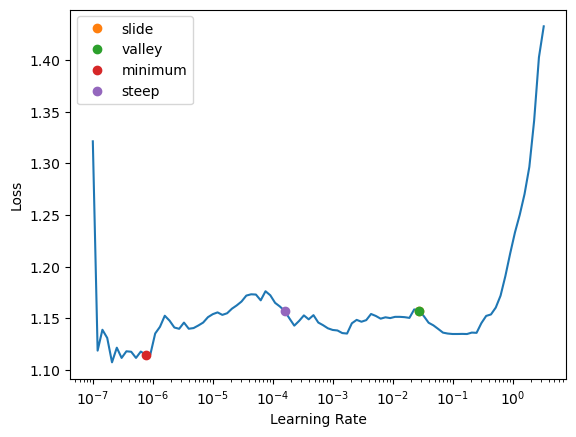

In [30]:
lr_slide, lr_valley, lr_min, lr_steep = learn \
    .lr_find(suggest_funcs=(slide, valley, minimum, steep))
    
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
print(f"Slide: {lr_slide:.2e}, Valley: {lr_valley:.2e}")

In [34]:
print("Before freezing:")
for param in learn.model.parameters():
    print(param.requires_grad)  # True if the layer is trainable, False if frozen
    
learn.freeze()

print("After freezing:")
for param in learn.model.parameters():
    print(param.requires_grad)


Before freezing:
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
After freezing:
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

In [35]:
for name, param in learn.model.named_parameters():
    print(f"Layer {name}, trainable: {param.requires_grad}")


Layer backbone.conv1.weight, trainable: True
Layer backbone.bn1.weight, trainable: True
Layer backbone.bn1.bias, trainable: True
Layer backbone.layer1.0.conv1.weight, trainable: True
Layer backbone.layer1.0.bn1.weight, trainable: True
Layer backbone.layer1.0.bn1.bias, trainable: True
Layer backbone.layer1.0.conv2.weight, trainable: True
Layer backbone.layer1.0.bn2.weight, trainable: True
Layer backbone.layer1.0.bn2.bias, trainable: True
Layer backbone.layer1.1.conv1.weight, trainable: True
Layer backbone.layer1.1.bn1.weight, trainable: True
Layer backbone.layer1.1.bn1.bias, trainable: True
Layer backbone.layer1.1.conv2.weight, trainable: True
Layer backbone.layer1.1.bn2.weight, trainable: True
Layer backbone.layer1.1.bn2.bias, trainable: True
Layer backbone.layer1.2.conv1.weight, trainable: True
Layer backbone.layer1.2.bn1.weight, trainable: True
Layer backbone.layer1.2.bn1.bias, trainable: True
Layer backbone.layer1.2.conv2.weight, trainable: True
Layer backbone.layer1.2.bn2.weight, t

In [43]:

learn.fit_one_cycle (12, lr_slide)
# learn.export('convnext_tiny.pkl')

KeyboardInterrupt: 

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

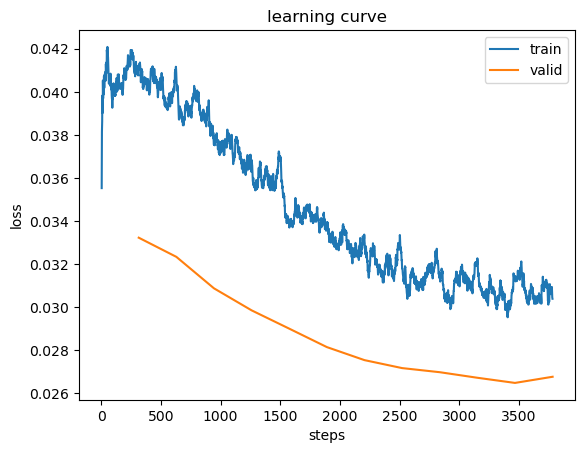

In [22]:
learn.recorder.plot_loss()

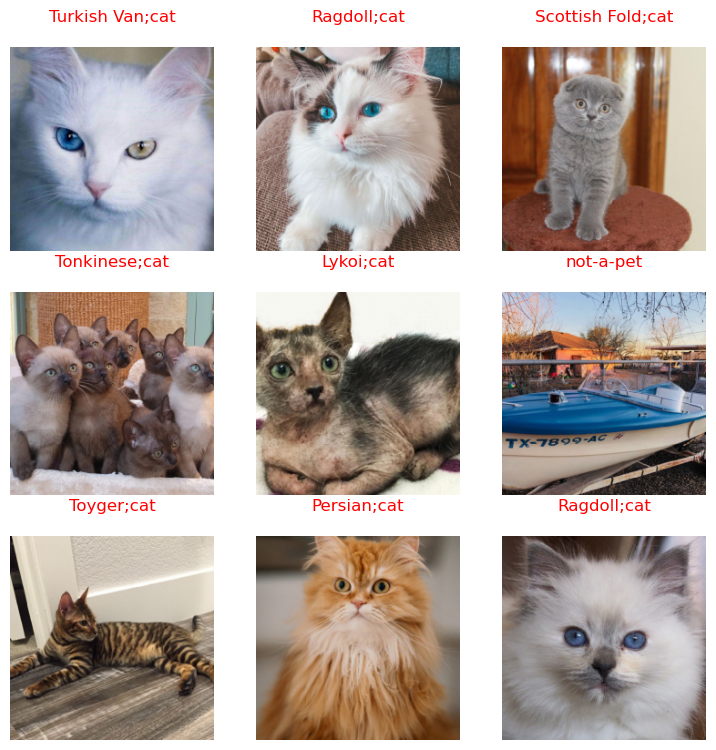

In [24]:
learn.show_results()

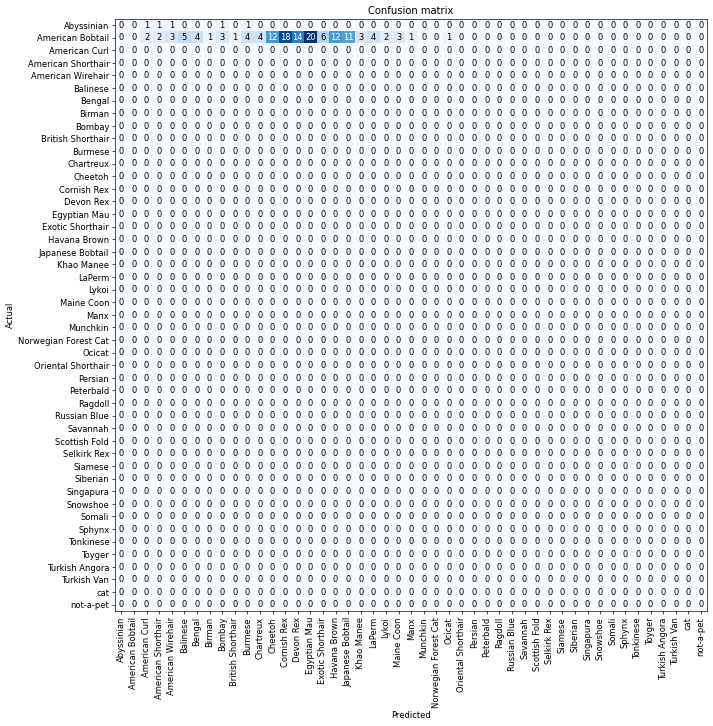

In [26]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
interp.most_confused(min_val=5)

[('American Bobtail', 'Egyptian Mau', 20),
 ('American Bobtail', 'Cornish Rex', 18),
 ('American Bobtail', 'Devon Rex', 14),
 ('American Bobtail', 'Cheetoh', 12),
 ('American Bobtail', 'Havana Brown', 12),
 ('American Bobtail', 'Japanese Bobtail', 11),
 ('American Bobtail', 'Exotic Shorthair', 6),
 ('American Bobtail', 'Balinese', 5)]

In [23]:
from fastai.vision.all import PILImage
from PIL import Image
import numpy as np

# Debug: Check if learn object is loaded
try:
    print(f"Model loaded: {learn}")
except NameError:
    print("Error: 'learn' object is not defined or not loaded.")

# Debug: Check if dls object is loaded
try:
    print(f"DataLoaders loaded: {dls}")
    print(f"Vocabulary: {dls.vocab}")
except NameError:
    print("Error: 'dls' object is not defined or not loaded.")
except AttributeError:
    print("Error: 'dls' object does not have the expected attributes.")


def perform_prediction(img_path, show_image=True):
    try:
        img = PILImage.create(img_path)
        if show_image: img.show()
        # print("Image loaded successfully.")
        # print(f"Image shape: {img.shape}")
        # print(f"Image type: {type(img)}")
    except Exception as e:
        print(f"Error loading image: {e}")

    # Predict on a new image
    try:
        pred, pred_idx, probs = learn.predict(img)
        probs = sigmoid(probs)
        # print(f"Predicted labels: {pred}")
        # print(f"Prediction indices: {pred_idx}")
        # print(f"Probabilities: {probs}")
    except Exception as e:
        print(f"Error in prediction: {e}")

    # Predict on a new image
    try:
        not_a_pet_idx = list(dls.vocab).index('not-a-pet')
        # print(f"Index of 'not-a-pet' in vocabulary: {not_a_pet_idx}")
    except Exception as e:
        print(f"Error finding 'not-a-pet' in vocabulary: {e}")

    # Set a threshold
    threshold = 0.2
    is_not_pet = probs[not_a_pet_idx] > threshold 

    if is_not_pet:
        return "This is not a pet image."
    else:
        # Get the top 5 predictions
        top5_idx = probs.argsort(descending=True)[:5]
        top5_probs = probs[top5_idx]
        top5_breeds = [dls.vocab[i] for i in top5_idx]

        # Format the output
        result = "Top 5 predictions:\n"
        for breed, prob in zip(top5_breeds, top5_probs):
            result += f"{breed}: {prob:.4f}\n"
        
        return result

Model loaded: <fastai.learner.Learner object at 0x7fad059ab850>
DataLoaders loaded: <fastai.data.core.DataLoaders object at 0x7fac1d145f90>
Vocabulary: ['Abyssinian', 'American Bobtail', 'American Curl', 'American Shorthair', 'American Wirehair', 'Balinese', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Burmese', 'Chartreux', 'Cheetoh', 'Cornish Rex', 'Devon Rex', 'Egyptian Mau', 'Exotic Shorthair', 'Havana Brown', 'Japanese Bobtail', 'Khao Manee', 'LaPerm', 'Lykoi', 'Maine Coon', 'Manx', 'Munchkin', 'Norwegian Forest Cat', 'Ocicat', 'Oriental Shorthair', 'Persian', 'Peterbald', 'Ragdoll', 'Russian Blue', 'Savannah', 'Scottish Fold', 'Selkirk Rex', 'Siamese', 'Siberian', 'Singapura', 'Snowshoe', 'Somali', 'Sphynx', 'Tonkinese', 'Toyger', 'Turkish Angora', 'Turkish Van', 'not-a-pet']


In [24]:
img_path = Path('test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg')
print(perform_prediction(img_path))



Error loading image: [Errno 2] No such file or directory: '/mnt/s/study/fastai_cat_clasifier/test/Abyssinian/05a5a708-5a74-40b3-826c-2cc47b6a50c0.jpg'
Error in prediction: cannot access local variable 'img' where it is not associated with a value


UnboundLocalError: cannot access local variable 'probs' where it is not associated with a value